# Record sales

This notebook analyses record sales in the `chinook.db` database with simulated record sales.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')
%matplotlib inline

In [2]:
DB="chinook.db"

In [3]:
def run_query(q, db=DB):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

In [4]:
def run_command(c, db=DB):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [5]:
def show_tables(dn=DB):
    q = """
    SELECT
        name,
        type
        FROM sqlite_master
    WHERE type IN ("table", "view");
    """
    tables = run_query(q)
    return tables

# A first look

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [7]:
genre_track_percentage = run_query(
    """
    SELECT
        g.name name,
        COUNT(t.genre_id) total,
        CAST(COUNT(t.genre_id) AS FLOAT) * 100 / (SELECT COUNT(*) FROM track) percentage
    FROM genre g
    JOIN track t ON t.genre_id=g.genre_id
    GROUP BY t.genre_id
    ORDER BY total DESC
    LIMIT 6""")
genre_track_percentage

,name,total,percentage
0,Rock,1297,37.025407
1,Latin,579,16.528690
2,Metal,374,10.676563
3,Alternative & Punk,332,9.477591
4,Jazz,130,3.711105
5,TV Shows,93,2.654867


In [8]:
def fancy_pie(df, percentages, labels, ax=None, cmap_name="Paired"):
    cmap=plt.get_cmap(cmap_name, len(df.index))
    df.plot.pie(
        y=percentages,
        autopct="%1.1f%%",
        labels=df[labels].values.tolist(),
        colors=[cmap(i) for i in range(len(df.index))],
        legend=False,
        ax=ax)

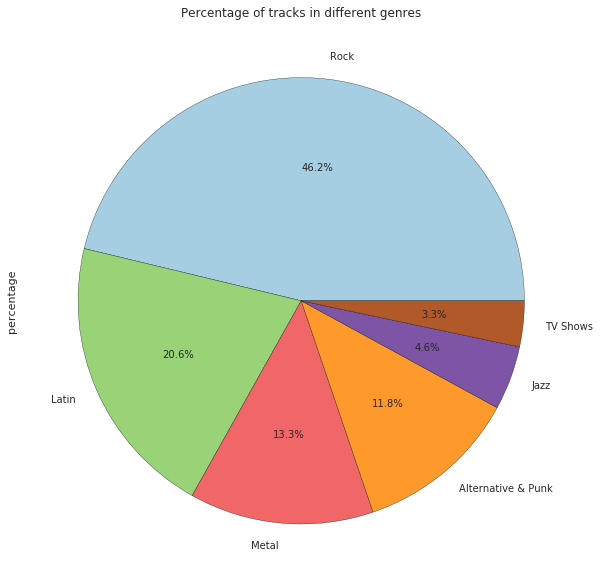

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
fancy_pie(genre_track_percentage, "percentage", "name", ax)
ax.set_title("Percentage of tracks in different genres")

Rock, Latin, Metal, and alternative make up 3/4 of the tracks
# Track sales in the USA

In [10]:
genre_sales_usa = run_query(
    """
    WITH usa_tracks AS
    (
        SELECT il.* FROM invoice_line il
        INNER JOIN invoice i on il.invoice_id = i.invoice_id
        INNER JOIN customer c on i.customer_id = c.customer_id
        WHERE c.country = "USA"
    )    
    SELECT
        g.name name,
        COUNT(uts.invoice_line_id) tracks_sold,
        CAST(COUNT(uts.invoice_line_id) AS FLOAT) * 100 / (
            SELECT COUNT(*) from usa_tracks
        ) percentage_sold
    FROM usa_tracks uts
    INNER JOIN track t on t.track_id = uts.track_id
    INNER JOIN genre g on g.genre_id = t.genre_id
    GROUP BY t.genre_id
    ORDER BY tracks_sold DESC
    LIMIT 10""")

,name,tracks_sold,percentage_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


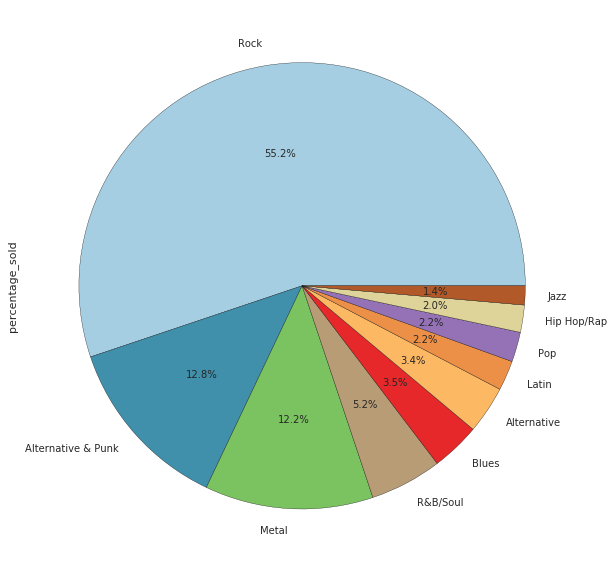

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
fancy_pie(genre_sales_usa, "percentage_sold", "name", ax)
genre_sales_usa

Most bought artists

In [12]:
artist_sales_usa = run_query("""
WITH usa_tracks AS
(
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
)    
SELECT
    ar.name name,
    t.name track,
    al.title album,
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    CAST(COUNT(uts.invoice_line_id) AS FLOAT) * 100 / (
        SELECT COUNT(*) from usa_tracks
    ) percentage_sold
FROM usa_tracks uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
INNER JOIN artist ar on ar.artist_id = al.artist_id
INNER JOIN album al on al.album_id = t.album_id
GROUP BY ar.artist_id
ORDER BY tracks_sold DESC
LIMIT 10""")

,name,track,album,genre,tracks_sold,percentage_sold
0,Van Halen,How Many Say I,Van Halen III,Rock,43,4.091342
1,R.E.M.,New Test Leper,New Adventures In Hi-Fi,Rock,38,3.615604
2,The Rolling Stones,The Worst,Voodoo Lounge,Rock,37,3.520457
3,Nirvana,Milk It,From The Muddy Banks Of The Wishkah [live],Rock,35,3.330162
4,Eric Clapton,Esotérico,Unplugged,Latin,34,3.235014
5,Foo Fighters,What If I Do?,In Your Honor [Disc 2],Rock,34,3.235014
6,Green Day,Hitchin' A Ride,International Superhits,Alternative & Punk,32,3.044719
7,Guns N' Roses,Live and Let Die,Use Your Illusion I,Rock,32,3.044719
8,Pearl Jam,Help Help,Riot Act,Rock,31,2.949572
9,Amy Winehouse,You Know I'm No Good (feat. Ghostface Killah),Back to Black,R&B/Soul,30,2.854424


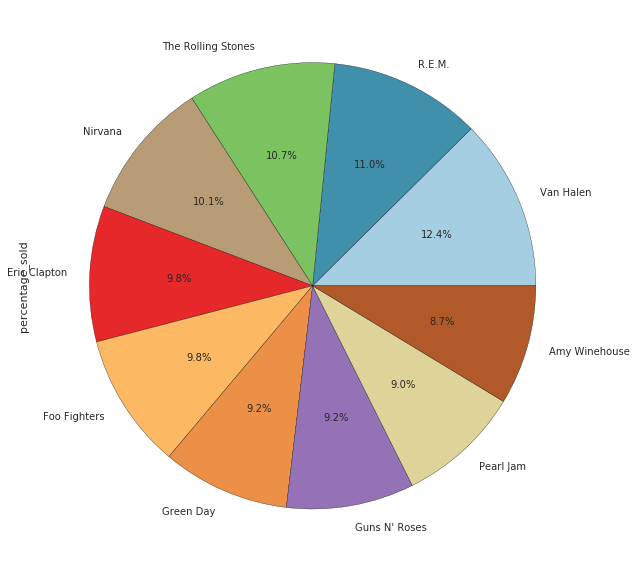

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
fancy_pie(artist_sales_usa, "percentage_sold", "name", ax)
artist_sales_usa

# Employee Sales Performance¶


In [14]:
employee_sales_performance = run_query('''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY employee;
''')

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


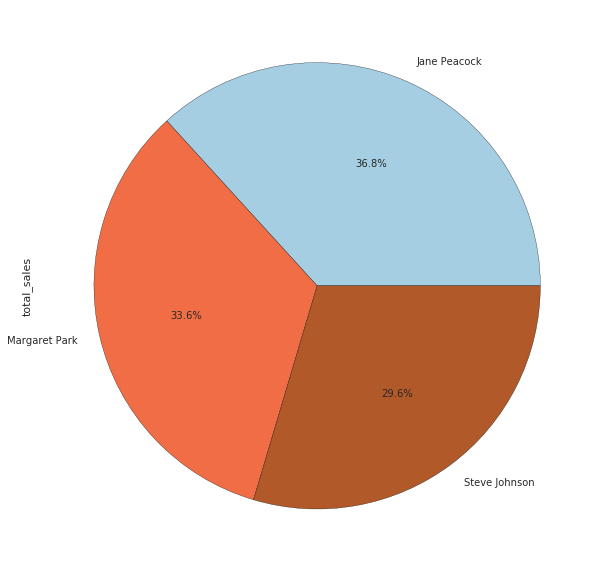

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
fancy_pie(employee_sales_performance, "total_sales", "employee", ax)
employee_sales_performance

Jane is dominating an even race, but Steve probably needs to improve a little.

In [16]:
sales_by_country = run_query('''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
''')

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


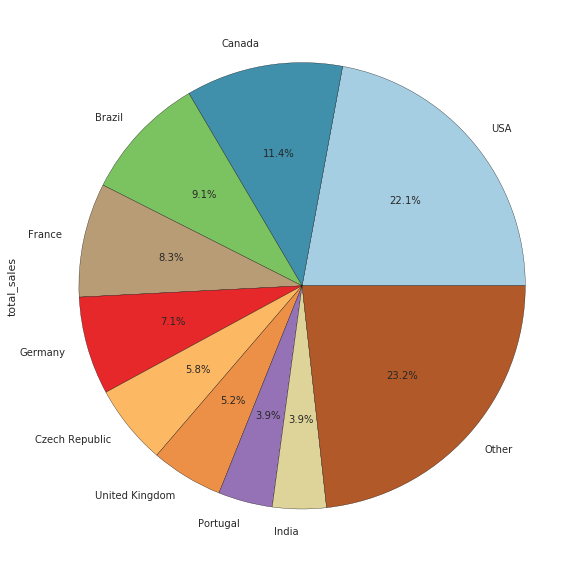

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
fancy_pie(sales_by_country, "total_sales", "country", ax)
sales_by_country

Sales are dominated by USA, Canada, Brazil, & France

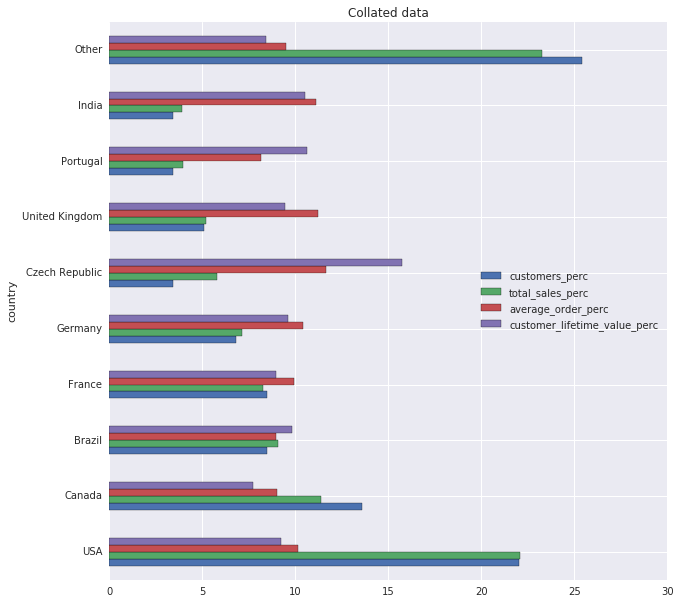

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
def perc(x):
    return 100*x/x.sum()
sales_by_country["customers_perc"]=perc(sales_by_country["customers"])
sales_by_country["total_sales_perc"]=perc(sales_by_country["total_sales"])
sales_by_country["average_order_perc"]=perc(sales_by_country["average_order"])
sales_by_country["customer_lifetime_value_perc"]=perc(sales_by_country["customer_lifetime_value"])
sales_perc = sales_by_country[[
    "customers_perc", "total_sales_perc", "average_order_perc", "customer_lifetime_value_perc"]]
sales_perc.index = sales_by_country["country"];
sales_perc.plot.barh(ax=ax, title="Collated data");

_Average orders_ and _customer life time value_ is higher in Czeck republic, while  _customers_ and _total sales_ are higher in the USA.

In [21]:
albums_vs_tracks = run_query('''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) * 100 / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
''')

In [22]:
albums_vs_tracks

,album_purchase,number_of_invoices,percent
0,no,500,81.433225
1,yes,114,18.566775


Only 18% of purchases are albums.